# Survival Analysis for MIP Solver Running Time

Inspired by the recent activity in open-source MIP solvers ([HiGHS](https://highs.dev/) is becoming stable after the 1.0 release and many users submitting bug reports, [SCIP](https://scipopt.org/index.php#news) has become open-source software), I wanted to revisit some folklore about running times.

When solving difficult problems, in particular, when running computational experiments, we have to choose a timelimit to tell the solver when to give up solving the problem (that is finding a solution and proving its optimality). If the timelimit is chosen too small, many instances will not be solved within it and therefore we can not compare the running time between different solvers or settings. But if we set the timelimit to long, we might waste computational resources while waiting for a result that never comes.

I remember the rule of thumb:

> If the problem is not solved within an hours, it will also not be solved after four hours (or later).

Let's see if we can use some data and [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) to confirm this rule.

In [1]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def make_ax():
    fig = plt.figure(figsize=(12, 9))
    ax = fig.subplots()
    return ax

## Data Prep

We use running time data from the [Mittelmann benchmarks](http://plato.la.asu.edu/bench.html) on the [MIPLIB](http://miplib.zib.de/) set of benchmark instances, a set of representative difficult MIP instances.

From the solver comparison, we only look at the open-source solvers still in active development: HiGHS and SCIP.
The timelimit was set as 2 hours (7200 seconds), which we use as our window of observation. The tables contain either the time to optimality (solved instance) or some exceptional status (either timout or an error). We interpret all exceptions as [right-censored](https://en.wikipedia.org/wiki/Survival_analysis#Censoring) data.

In [3]:
# Read in MIPLIP results (subset of solvers, converted to CSV)
times = pd.read_csv("../files/miplib_20221113_8threads.csv")
times.head()

,Instance,HiGHS,SCIP
0,30n20b8,537,69
1,50v-10,5508,timeout
2,academictimetablesmall,timeout,timeout
3,air05,22,24
4,app1-1,23,3


In [4]:
# Bring table in long form, not separate columns per solver
times = pd.melt(times, id_vars="Instance", var_name="Solver", value_name="Runtime")
times.set_index(["Solver", "Instance"], inplace=True)

In [5]:
# Replace exceptional status with time limit
for status in ["abort", "mismatch", "timeout"]:
    times.replace(status, 7200, inplace=True)

# Convert all values to numbers
times["Runtime"] = times["Runtime"].astype(float)

In [6]:
# Identify the instances that have been solved properly within the time limit.
# The others are right-censored, that is, we don't know how long it would have taken to solve them,
# including cases with an error status.
times["Finished"] = 1 * (times["Runtime"] < 7200)
times.head()

Runtime  Finished
Solver Instance                                 
HiGHS  30n20b8                   537.0         1
       50v-10                   5508.0         1
       academictimetablesmall   7200.0         0
       air05                      22.0         1
       app1-1                     23.0         1

## Kaplan-Meier Estimate

We apply the [Kaplan-Meier](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator) estimate to draw survival curves for each solver.

These show the probability that an instance has survived for some time (ie, has not yet been solved to optimality), together with a 95% confidence interval.

Note that the curves (one for each solver) start at 100% for time 0 and decrease monotonically. The curves stop at 7200s (the time limit set) but have not reached 0%, because of some instances that have not been solved.

We can see a steep decline in the first few minutes, while the curves flattens to a long tail, as predicted by our rule of thumb.

In [7]:
def kaplan_meier(solver, ax=None):
    kmf = KaplanMeierFitter()
    kmf.fit(
        times.loc[solver]["Runtime"],
        event_observed=times.loc[solver]["Finished"],
        label=solver,
    )
    return kmf.plot_survival_function(ax=ax)

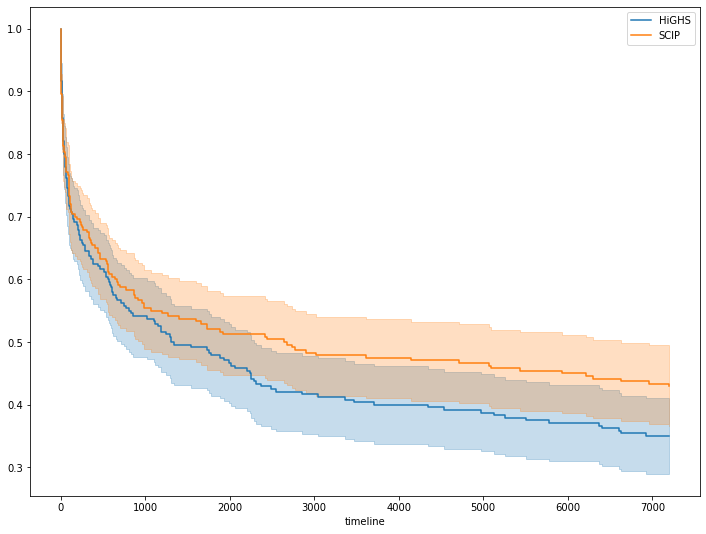

In [8]:
ax = make_ax()
for s in ["HiGHS", "SCIP"]:
    kaplan_meier(s, ax)

## Conditional Survival

We can also look at conditional survival, considering only that part of the curves beyond the first hour.
That is, we reframe our questions from

> What is the probability that an instance has survived (*not* been solved) after some time?

to 

> What is the probabilty that an instance is solved after some time of additional waiting, knowing that it wasn't solver after the first hour?

To that end, we merge the data from both solvers and make some adjustments to the resulting survival curve.

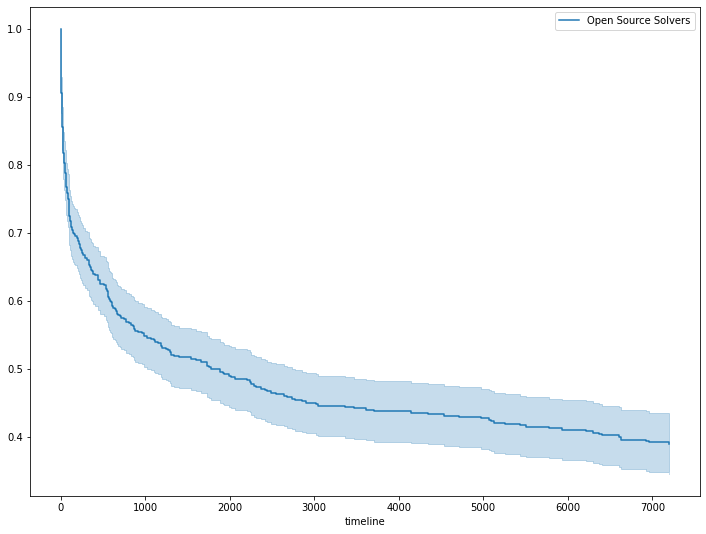

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(
    times["Runtime"],
    event_observed=times["Finished"],
    label="Open Source Solvers"
)
ax = make_ax()
kmf.plot_survival_function(ax=ax);

In [10]:
# Only keep right tail of curve, going beyond 1h
survival = kmf.survival_function_["Open Source Solvers"]
tail = survival[3600:]
tail.index = tail.index - 3600.0

In [11]:
# Rescale probability to start at 100% (conditional on surviving 1h),
# and negate the probability (solving it within time).
cond_tail = 1.0 - tail / tail.iloc[0]

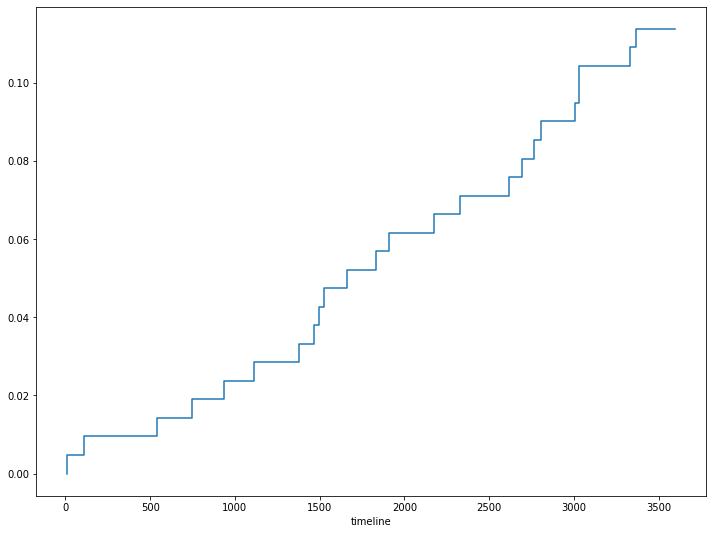

In [12]:
# Visualize probability of solving it after waiting for additional time, after 1h.
ax = make_ax()
cond_tail.plot(ax=ax, drawstyle="steps-pre");

The above chart shows the probability than instance is solved after some time (beyond 1h), given that it wasn't solved already. It tells us that an additional hour of computation would only solve about 10% of the remaining instances.